# Profiles

This notebook walks through how one can create density profiles which can, in turn, be used to compute either the $T_{\rm kSZ}$ profile or the $\Delta \Sigma$ profile.

In [2]:
# preamble 
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from init_halo_model import (  # halo model
    a_arr,
    bM,
    cM_relation,
    cosmo,
    hmc,
    hmd,
    k_arr,
    r_arr,
)

import glasz

# CMASS PARAMETERS
z_lens = 0.55  # Mean z for CMASS
a_sf = 1 / (1 + z_lens)

# constituent fractions
fb = cosmo["Omega_b"] / cosmo["Omega_m"] # Baryon fraction
fc = cosmo["Omega_c"] / cosmo["Omega_m"] # CDM fraction

# define 2-halo term
xi_mm_2h = glasz.profiles.calc_xi_mm_2h(
    cosmo, hmd, cM_relation, hmc, k_arr, a_arr, r_arr, a_sf
)


The `glasz.profiles` subpackage is built on the `pyccl.halos` package. For this reason, there are several assumptions that go into arguments of these functions. The most important is that all profiles assume comoving units with no factors of $h$ in units. We can start by making the Generalized NFW (GNFW) profile which is what we use to describe the gas (baryon) density profile. The GNFW profile has the form 

$$
    \rho_{\rm GNFW}(r) = \rho_0 \left( \frac{x}{x_{\rm c}} \right)^{-\gamma} \left( 1 + \left(\frac{x}{x_{\rm c}} \right)^{1/\alpha} \right)^{-(\beta - \gamma) \alpha} \; ,
$$

which has 5 parameters: the amplitude $\rho_0$, inner power law slope $\gamma$ ($x \ll 1$), intermediate power law slope $\alpha$ ($x \sim 1$), and the outer power law slope $\beta$ ($x \gg 1$), and the core scale fraction $x_{\rm c}$. 

In [12]:
# Halo Mass
M_halo = 3e13 

# GNFW Parameters
rho0 = 1.0
alpha = 1.0 
beta = 3.0
gamma = 0.2
x_c = 0.5

prof_GNFW = glasz.profiles.HaloProfileGNFW(
    hmd,
    rho0=rho0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    x_c=x_c,
)

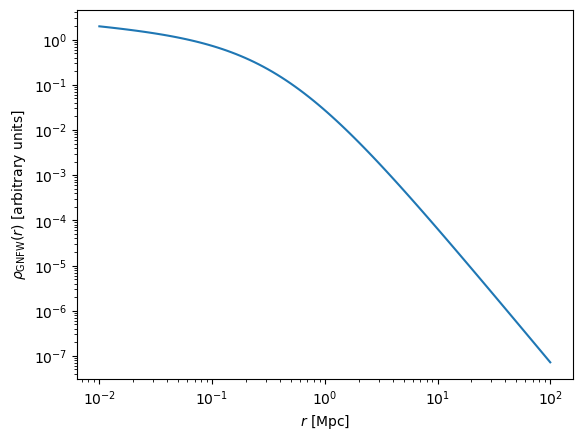

In [33]:
f, ax = plt.subplots(1, 1)
ax.loglog(r_arr, prof_GNFW.real(cosmo, r_arr, M_halo, a_sf))
ax.set_xlabel("$r$ [Mpc]")
ax.set_ylabel(r"$\rho_{\rm GNFW}(r)$ [arbitrary units]")
plt.show()


If we want to make this profile physical, we can normalize it relative to an NFW profile such that at the baryon radius $r_{b}$ the mass enclosed within the GNFW profile is $f_{\rm b} \times M_{\rm halo}$. In other words 
$$
    f_{\rm b} = \frac{\int_0^{r_{\rm b}} 4 \pi r^2 dr \; \rho^{\rm 1h}_{\rm b}(r)}{\int_0^{r_{\rm b}} 4 \pi r^2 dr \; \rho^{\rm 1h}_{\rm m}(r)} \; .
$$
Using this condition, we solve for the baryon density amplitude $\rho_0$ to get 
$$
    \rho_0 = \frac{\int_0^{r_{\rm b}} r^2 \rho_{\rm NFW}(r)}{\int_0^{r_{\rm b}} r^2 \left( \frac{x}{x_{\rm c}} \right)^{-\gamma} \left( 1 + \left(\frac{x}{x_{\rm c}} \right)^{1/\alpha} \right)^{-(\beta - \gamma) \alpha}} \; .
$$
This removes $\rho_0$ as a free parameter in the model. We demonstrate how to do this below. For more details

In [34]:
Rb = 10 * (hmd.get_radius(cosmo, M_halo, a_sf) / a_sf)

# COMPUTE GNFW AMPLITUDE
prof_nfw = ccl.halos.HaloProfileNFW(
    mass_def=hmd, concentration=cM_relation, truncated=False, fourier_analytic=True
)

prof_baryons = glasz.profiles.HaloProfileGNFW(
    hmd,
    rho0=1.0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    x_c=x_c,
)

prof_baryons.normalize(cosmo, Rb, M_halo, a_sf, prof_nfw) #normalize relative to NFW profile

We can plot this below.

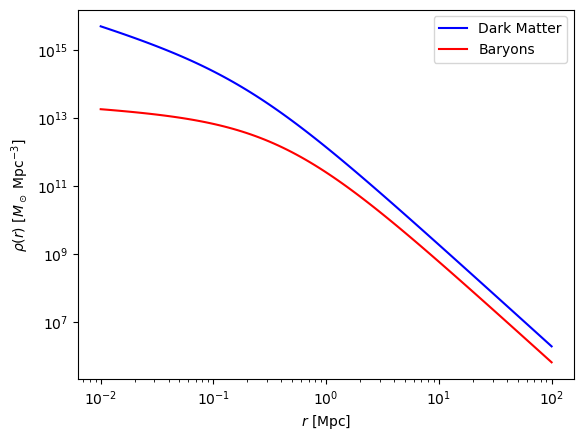

In [35]:
f, ax = plt.subplots(1, 1)
ax.loglog(r_arr, prof_nfw.real(cosmo, r_arr, M_halo, a_sf) * fc, label="Dark Matter", color="blue") #CDM profile
ax.loglog(r_arr, prof_baryons.real(cosmo, r_arr, M_halo, a_sf) * fb, label="Baryons", color="red") #Baryon profile
ax.set_xlabel("$r$ [Mpc]")
ax.set_ylabel(r"$\rho(r)$ [$M_\odot$ Mpc$^{-3}$]")
ax.legend()
plt.show()

Now that we have the normalization of the GNFW profile to become the baryon (gas) profile. We can also throw in a 2-halo term for each. For more details on how this is done, see the 2-halo section of the documentation.

In [36]:
# Amplitude of the 2-halo term
A_2h = 1.0

# Define the 2-halo term from ξ_mm^2h
def rho_2h(r):
    return (
        xi_mm_2h(r)
        * bM(cosmo, M_halo, a_sf)
        * ccl.rho_x(cosmo, a_sf, "matter", is_comoving=True)
        * A_2h
    )

prof_baryons.rho_2h = rho_2h  # add 2-halo term to baryon profile

With this we can plot the baryon (gas) profile. This is what is probed by the $T_{\rm kSZ}$ measurements.

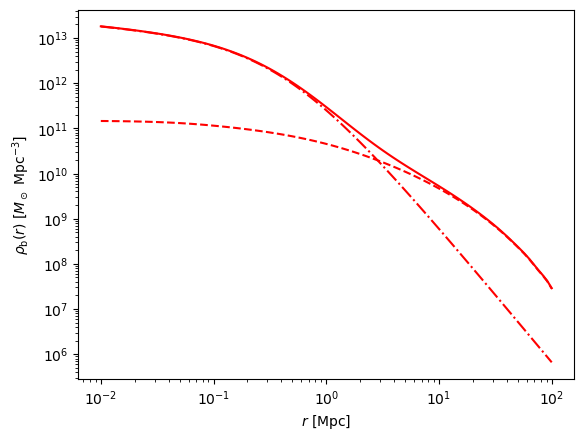

In [38]:
f, ax = plt.subplots(1, 1)
ax.loglog(r_arr, 
            prof_baryons.real(cosmo, r_arr, M_halo, a_sf) * fb, 
            color="red") #Baryon profile
ax.loglog(r_arr, 
            (prof_baryons.real(cosmo, r_arr, M_halo, a_sf) - rho_2h(r_arr)) * fb, ls="-.",
            color="red") # 1-halo term
ax.loglog(r_arr, 
            rho_2h(r_arr) * fb, ls="--", 
            color="red") #2-halo term
ax.set_xlabel("$r$ [Mpc]")
ax.set_ylabel(r"$\rho_{\rm b}(r)$ [$M_\odot$ Mpc$^{-3}$]")
plt.show()

We can finally combine everything to form the matter profile which is what is probed by $\Delta \Sigma$

In [39]:
prof_matter = glasz.profiles.MatterProfile(
    mass_def=hmd, concentration=cM_relation, rho_2h=rho_2h
)

Lastly, we plot.

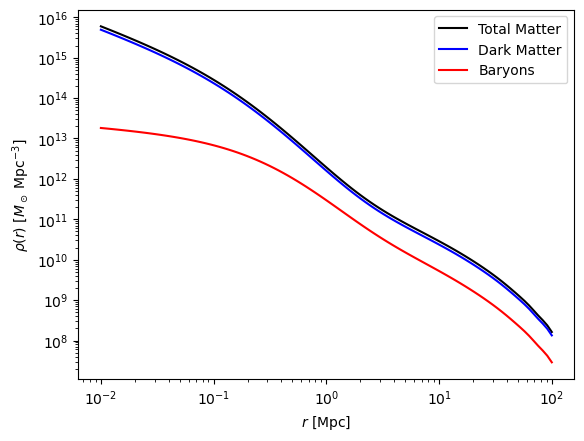

In [41]:
f, ax = plt.subplots(1, 1)
ax.loglog(r_arr, prof_matter.real(cosmo, r_arr, M_halo, a_sf), color="black", label="Total Matter")
ax.loglog(r_arr, (prof_nfw.real(cosmo, r_arr, M_halo, a_sf) + rho_2h(r_arr)) * fc, color="blue", label="Dark Matter")
ax.loglog(r_arr, (prof_baryons.real(cosmo, r_arr, M_halo, a_sf)) * fb, color="red", label="Baryons")
ax.set_xlabel("$r$ [Mpc]")
ax.set_ylabel(r"$\rho(r)$ [$M_\odot$ Mpc$^{-3}$]")
ax.legend()
plt.show()


### GNFW Parameters as a Function of Mass

In [Battaglia et al. 2016](https://arxiv.org/pdf/1607.02442), relationships were fit using hydro cosmological simulations to describe $\alpha$, $\beta$, and $\rho_0$ as a function of halo mass and redshift. There are two prescriptions: 

* "AGN" - Simulations with AGN feedback (strong feedback)
* "SH" - Simulations with Adiabatic Cooling (mild feedback)

We have implemented these in `glasz.profiles` and they can be accessed via


In [42]:
profile_gas_AGN = glasz.profiles.HaloProfileGNFW(
        mass_def=hmd,
        feedback_model="AGN",
        truncated=False,
)

profile_gas_SH = glasz.profiles.HaloProfileGNFW(
    mass_def=hmd,
    feedback_model="SH",
    truncated=False,
)

We plot as a function of mass

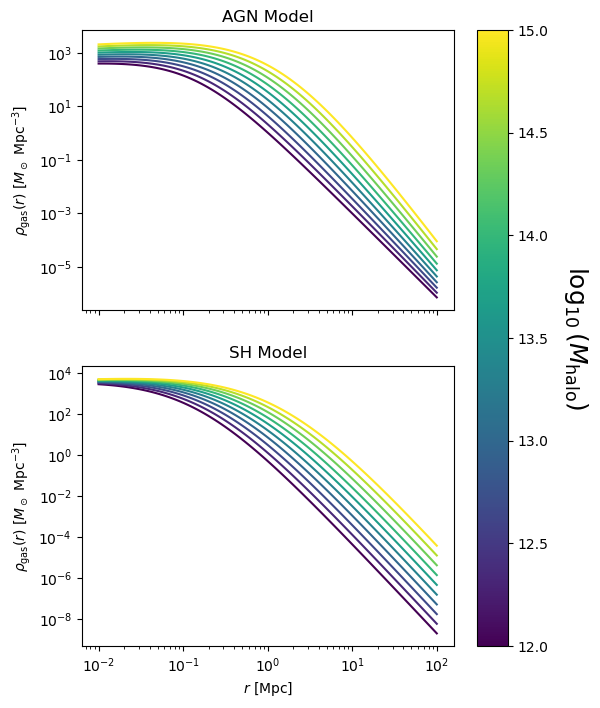

In [65]:
M_arr = np.geomspace(1e12, 1e15, 10)
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(M_arr)))

f, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

for i in range(len(M_arr)):
    axes[0].loglog(r_arr, profile_gas_AGN.real(cosmo, r_arr, M_arr[i], a_sf), color=colors[i])
    axes[1].loglog(r_arr, profile_gas_SH.real(cosmo, r_arr, M_arr[i], a_sf), color=colors[i])

for ax in axes:
    ax.set_ylabel(r"$\rho_{\rm gas}(r)$ [$M_\odot$ Mpc$^{-3}$]")

norm_scaling = plt.cm.colors.Normalize(vmin=np.log10(M_arr[0]), vmax=np.log10(M_arr[-1])) #set the max and min y value for your cmap
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm_scaling, cmap=cmap), ax=axes) #create color bar object
cbar.set_label(r"$\log_{10}(M_{\rm halo})$",rotation=270,labelpad=30, fontsize=18) #give cbar a label and rotate it 

axes[1].set_xlabel("$r$ [Mpc]")
axes[0].set_title("AGN Model")
axes[1].set_title("SH Model")
# ax.legend()
plt.show()

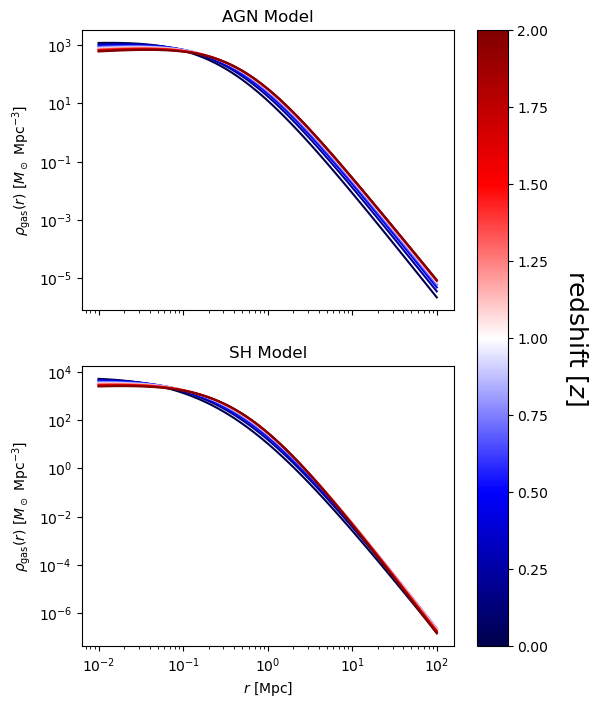

In [69]:
z_arr = np.linspace(0, 2, 10)
cmap = plt.cm.seismic
colors = cmap(np.linspace(0, 1, len(z_arr)))

f, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

for i in range(len(M_arr)):
    axes[0].loglog(r_arr, profile_gas_AGN.real(cosmo, r_arr, M_halo, 1/(1 + z_arr[i])), color=colors[i])
    axes[1].loglog(r_arr, profile_gas_SH.real(cosmo, r_arr, M_halo, 1/(1 + z_arr[i])), color=colors[i])

for ax in axes:
    ax.set_ylabel(r"$\rho_{\rm gas}(r)$ [$M_\odot$ Mpc$^{-3}$]")

norm_scaling = plt.cm.colors.Normalize(vmin=(z_arr[0]), vmax=(z_arr[-1])) #set the max and min y value for your cmap
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm_scaling, cmap=cmap), ax=axes) #create color bar object
cbar.set_label(r"redshift [$z$]",rotation=270,labelpad=30, fontsize=18) #give cbar a label and rotate it 

axes[1].set_xlabel("$r$ [Mpc]")
axes[0].set_title("AGN Model")
axes[1].set_title("SH Model")
# ax.legend()
plt.show()